In [1]:
# load sample document
with open('input/sample.txt') as f:
    texts = f.read().splitlines()

In [2]:
texts

['Months before the Supreme Court overturned Roe v. Wade, the federal appeals court based in this Southern city cleared the way to ban most abortions in Texas. The same court appeared to jump the line to block the White House’s signature coronavirus vaccination mandate and split from other courts to back restrictions on social media companies and constrain President Biden’s immigration powers.',
 'The U.S. Court of Appeals for the 5th Circuit in New Orleans has long leaned conservative. But the arrival of a half-dozen judges picked by President Donald Trump — many of them young, ambitious and outspoken — has put the court at the forefront of resistance to the Biden administration’s assertions of legal authority and to the regulatory power of federal agencies. Their rulings have at times broken with precedent and exposed rifts among the judges, illustrating Trump’s lasting legacy on the powerful set of federal courts that operate one step below the Supreme Court. Even some veteran conse

In [3]:
# Load spacy model

import spacy
nlp = spacy.load('en_core_web_sm')

In [4]:
# Import plotting library
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)

In [5]:
# Process input document with spacy and break it into sentences

sents = []
for text in texts:
    doc = nlp(text)
    for sent in doc.sents:
        sents.append(sent)

In [6]:
sents

[Months before the Supreme Court overturned Roe v. Wade, the federal appeals court based in this Southern city cleared the way to ban most abortions in Texas.,
 The same court appeared to jump the line to block the White House’s signature coronavirus vaccination mandate and split from other courts to back restrictions on social media companies and constrain President Biden’s immigration powers.,
 The U.S. Court of Appeals for the 5th Circuit in New Orleans has long leaned conservative.,
 But the arrival of a half-dozen judges picked by President Donald Trump — many of them young, ambitious and outspoken — has put the court at the forefront of resistance to the Biden administration’s assertions of legal authority and to the regulatory power of federal agencies.,
 Their rulings have at times broken with precedent and exposed rifts among the judges, illustrating Trump’s lasting legacy on the powerful set of federal courts that operate one step below the Supreme Court.,
 Even some veteran 

In [7]:
"""LDA based segmentation"""

'LDA based segmentation'

In [8]:
# Select tokens while ignoring punctuations and stopwords, and lowercase them
MIN_LENGTH = 3
tokenized_sents = [[token.lemma_.lower() for token in sent if 
                    not token.is_stop and not token.is_punct and token.text.strip() and len(token) >= MIN_LENGTH] 
                    for sent in sents]

In [9]:
# Build gensim dictionary and topic model
from gensim import corpora, models
import numpy as np

np.random.seed(123)

N_TOPICS = 5
N_PASSES = 5

dictionary = corpora.Dictionary(tokenized_sents)
bow = [dictionary.doc2bow(sent) for sent in tokenized_sents]
topic_model = models.LdaModel(corpus=bow, id2word=dictionary, num_topics=N_TOPICS, passes=N_PASSES)

topic_model.show_topics()

[(0,
  '0.050*"court" + 0.026*"judge" + 0.018*"republican" + 0.018*"supreme" + 0.018*"far" + 0.018*"president" + 0.010*"texas" + 0.010*"contender" + 0.010*"opening" + 0.010*"see"'),
 (1,
  '0.031*"court" + 0.030*"5th" + 0.030*"circuit" + 0.021*"orleans" + 0.021*"new" + 0.012*"judge" + 0.012*"federal" + 0.012*"trump" + 0.012*"president" + 0.011*"biden"'),
 (2,
  '0.006*"conservative" + 0.005*"circuit" + 0.005*"appeals" + 0.005*"5th" + 0.005*"lean" + 0.005*"u.s." + 0.005*"long" + 0.005*"court" + 0.005*"new" + 0.005*"orleans"'),
 (3,
  '0.045*"court" + 0.019*"case" + 0.019*"law" + 0.019*"georgetown" + 0.019*"supreme" + 0.019*"federal" + 0.019*"conservative" + 0.019*"judge" + 0.011*"say" + 0.011*"gervasi"'),
 (4,
  '0.037*"school" + 0.030*"judge" + 0.023*"texas" + 0.023*"law" + 0.016*"controversial" + 0.016*"trump" + 0.016*"conservative" + 0.016*"5th" + 0.016*"pick" + 0.016*"circuit"')]

In [10]:
# Infer topics with minimum threshold
THRESHOLD = 0.05
doc_topics = list(topic_model.get_document_topics(bow, minimum_probability=THRESHOLD))

In [11]:
doc_topics[:10]

[[(3, 0.9553131)],
 [(0, 0.965127)],
 [(1, 0.92673564)],
 [(1, 0.96641266)],
 [(0, 0.95975894)],
 [(0, 0.8991579)],
 [(0, 0.9526328)],
 [(0, 0.9528284)],
 [(4, 0.93837)],
 [(4, 0.9651593)]]

In [12]:
# get top k topics for each sentence
k = 3
top_k_topics = [[t[0] for t in sorted(sent_topics, key=lambda x: x[1], reverse=True)][:k] 
                for sent_topics in doc_topics]

In [13]:
top_k_topics[:10]

[[3], [0], [1], [1], [0], [0], [0], [0], [4], [4]]

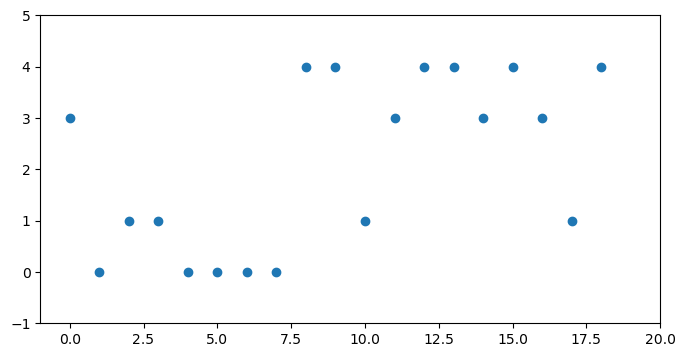

In [14]:
# Scatter plots of topic distribution

plt.ylim(-1, N_TOPICS)
plt.xlim(-1, len(sents)+1)

plot_data_x = []
plot_data_y = []

for i, elem in enumerate(top_k_topics):
    for topic in elem:
        plot_data_x.append(i)
        plot_data_y.append(topic)

import matplotlib.pyplot as plt
plt.scatter(plot_data_x, plot_data_y)

In [15]:
# Compute similarity vector from topics

In [16]:
from itertools import islice
import numpy as np

def window(seq, n=3):
    """https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator
    Returns a sliding window of width n over data from the iterable seq"""
    
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [17]:
from itertools import chain

WINDOW_SIZE = 3

window_topics = window(top_k_topics, n=WINDOW_SIZE)
window_topics = [list(set(chain.from_iterable(window))) for window in window_topics]

In [18]:
window_topics[:10]

[[0, 1, 3],
 [0, 1],
 [0, 1],
 [0, 1],
 [0],
 [0],
 [0, 4],
 [0, 4],
 [1, 4],
 [1, 3, 4]]

In [19]:
# Encode topics for similarity computation

from sklearn.preprocessing import MultiLabelBinarizer

binarizer = MultiLabelBinarizer(classes=range(N_TOPICS))

encoded_topics = binarizer.fit_transform(window_topics)

In [20]:
encoded_topics[:10]

array([[1, 1, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [0, 1, 0, 0, 1],
       [0, 1, 0, 1, 1]])

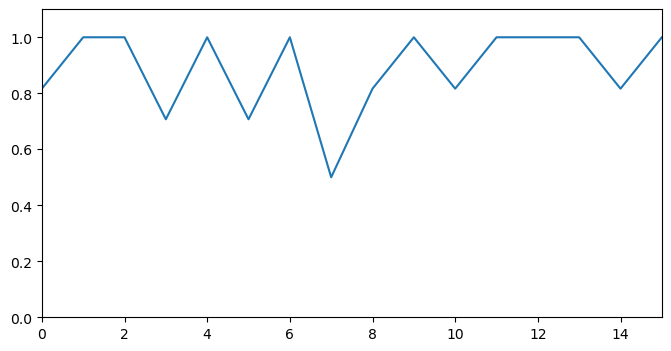

In [21]:
# Compute coherence scores

from sklearn.metrics.pairwise import cosine_similarity

coherence_scores = [cosine_similarity([pair[0]], [pair[1]])[0][0] 
                    for pair in zip(encoded_topics, encoded_topics[1:])]

plt.ylim(0, 1.1)
plt.xlim(0, len(coherence_scores)-1)
plt.plot(coherence_scores)

In [22]:
# Store length of signal
n = len(coherence_scores)

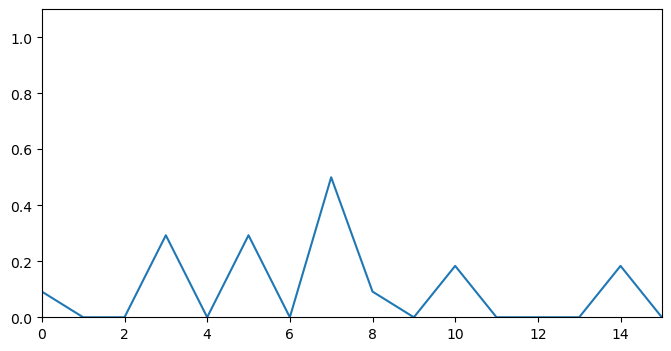

In [23]:
# Compute depth scores

def get_depths(scores):
    """Given a sequence of coherence scores of length n, compute a sequence of depth scores of similar length"""
    
    def climb(seq, i, mode='left'):
        """Given a sequence seq of values and index i, advance the index either to the right or left while the 
        value keeps increasing, then return the value at new index
        """
        if mode == 'left':
            while True:
                curr = seq[i]
                if i == 0:
                    return curr
                i = i-1
                if not seq[i] > curr:
                    return curr

        if mode == 'right':
            while True:
                curr = seq[i]
                if i == (len(seq)-1):
                    return curr
                i = i+1
                if not seq[i] > curr:
                    return curr
    
    depths = []
    for i in range(len(scores)):
        score = scores[i]
        l_peak = climb(scores, i, mode='left')
        r_peak = climb(scores, i, mode='right')
        depth = 0.5 * (l_peak + r_peak - (2*score))
        depths.append(depth)
        
    return np.array(depths)


depth_scores = get_depths(coherence_scores)

plt.xlim(0, n-1)
plt.ylim(0, 1.1)
plt.plot(depth_scores)

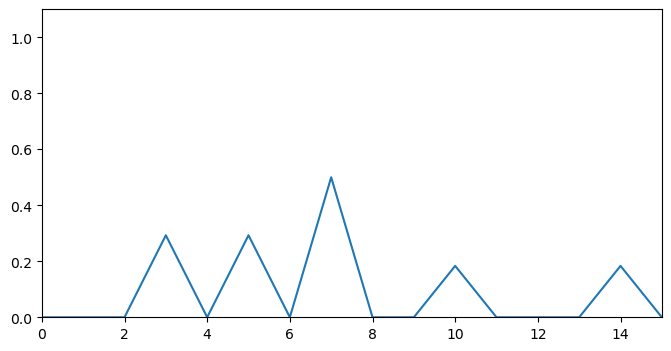

In [24]:
# Filter out local maxima
from scipy.signal import argrelmax

def get_local_maxima(depth_scores, order=1):
    """Given a sequence of depth scores, return a filtered sequence where only local maxima 
    selected based on the given order"""
    
    maxima_ids = argrelmax(depth_scores, order=order)[0]
    filtered_scores = np.zeros(len(depth_scores))
    filtered_scores[maxima_ids] = depth_scores[maxima_ids]
    return filtered_scores

# Get local maxima
filtered_scores = get_local_maxima(depth_scores, order=1)

plt.xlim(0, n-1)
plt.ylim(0, 1.1)
plt.plot(filtered_scores)

In [25]:
def compute_threshold(scores):
    """From Texttiling: https://aclanthology.org/J97-1003.pdf
    Automatically compute an appropriate threshold given a sequence of depth scores
    """
    s = scores[np.nonzero(scores)]
    threshold = np.mean(s) - (np.std(s) / 2)
    return threshold

# Automatic threshold computation
threshold = compute_threshold(filtered_scores)

In [26]:
print(threshold)

0.23276669011982865


In [27]:
# Select segments based on threshold

def get_threshold_segments(scores, threshold=0.1):
    """Given a sequence of depth scores, return indexes where the value is greater than the threshold"""
    
    segment_ids = np.where(scores >= threshold)[0]
    return segment_ids

segment_ids = get_threshold_segments(filtered_scores, threshold)

print(segment_ids)

[3 5 7]


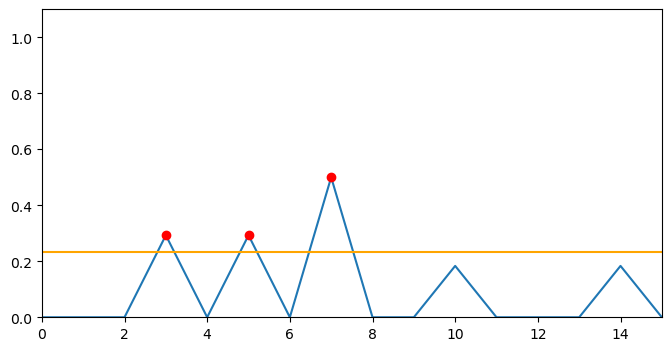

In [28]:
plt.xlim(0, n-1)
plt.ylim(0, 1.1)
plt.plot(filtered_scores)

# Plot threshold metadata
plt.plot(np.repeat(threshold, len(filtered_scores)), c='orange')
plt.plot(segment_ids, filtered_scores[segment_ids], 'o', c='red')

In [29]:
# Use computed ids to segment input document

segment_indices = segment_ids + WINDOW_SIZE

segment_indices = [0] + segment_indices.tolist() + [len(sents)]
slices = list(zip(segment_indices[:-1], segment_indices[1:]))

segmented = [sents[s[0]: s[1]] for s in slices]

In [30]:
segmented

[[Months before the Supreme Court overturned Roe v. Wade, the federal appeals court based in this Southern city cleared the way to ban most abortions in Texas.,
  The same court appeared to jump the line to block the White House’s signature coronavirus vaccination mandate and split from other courts to back restrictions on social media companies and constrain President Biden’s immigration powers.,
  The U.S. Court of Appeals for the 5th Circuit in New Orleans has long leaned conservative.,
  But the arrival of a half-dozen judges picked by President Donald Trump — many of them young, ambitious and outspoken — has put the court at the forefront of resistance to the Biden administration’s assertions of legal authority and to the regulatory power of federal agencies.,
  Their rulings have at times broken with precedent and exposed rifts among the judges, illustrating Trump’s lasting legacy on the powerful set of federal courts that operate one step below the Supreme Court.,
  Even some ve

In [31]:
# Print output

output = []
for elem in segmented:
    for i, s in enumerate(elem):
        output.append("- " + s.text)
    output.append("<SEGMENT>")
    
for elem in output:
    print(elem)

- Months before the Supreme Court overturned Roe v. Wade, the federal appeals court based in this Southern city cleared the way to ban most abortions in Texas.
- The same court appeared to jump the line to block the White House’s signature coronavirus vaccination mandate and split from other courts to back restrictions on social media companies and constrain President Biden’s immigration powers.
- The U.S. Court of Appeals for the 5th Circuit in New Orleans has long leaned conservative.
- But the arrival of a half-dozen judges picked by President Donald Trump — many of them young, ambitious and outspoken — has put the court at the forefront of resistance to the Biden administration’s assertions of legal authority and to the regulatory power of federal agencies.
- Their rulings have at times broken with precedent and exposed rifts among the judges, illustrating Trump’s lasting legacy on the powerful set of federal courts that operate one step below the Supreme Court.
- Even some veteran

In [32]:
# Save to file
with open('output/topic_output.txt','w') as file:
    file.write('\n'.join(output))

In [33]:
"""LLM based segmentation"""

'LLM based segmentation'

In [34]:
from src.utils import window, get_depths, get_local_maxima, get_threshold_segments, compute_threshold

In [35]:
# Load bert model

from sentence_transformers import SentenceTransformer

MODEL_STR = "sentence-transformers/all-MiniLM-L6-v2"

model = SentenceTransformer(MODEL_STR)

In [36]:
WINDOW_SIZE = 3

window_sent = list(window(sents, WINDOW_SIZE))
assert(len(window_sent) == (len(sents) - WINDOW_SIZE + 1))

window_sent = [' '.join([sent.text for sent in window]) for window in window_sent]

# Encode windowed
encoded_sent = model.encode(window_sent)

In [37]:
encoded_sent.shape

(17, 384)

In [38]:
# get pairs of windows

In [39]:
# compute coherence scores

from sklearn.metrics.pairwise import cosine_similarity

coherence_scores = [cosine_similarity([pair[0]], [pair[1]])[0][0] for pair in zip(encoded_sent, encoded_sent[1:])]

In [40]:
# Get signal length
n = len(coherence_scores)

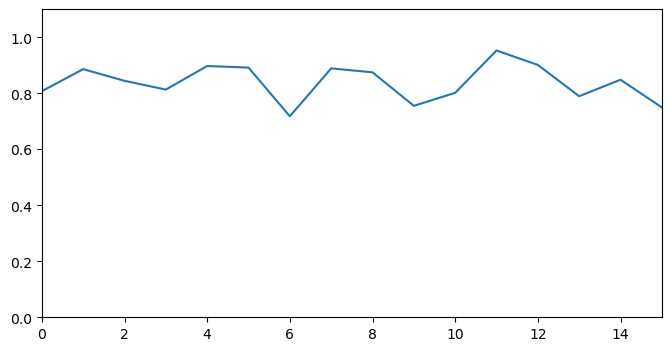

In [41]:
# Plot coherence scores
plt.xlim(0, n-1)
plt.ylim(0, 1.1)
plt.plot(coherence_scores)

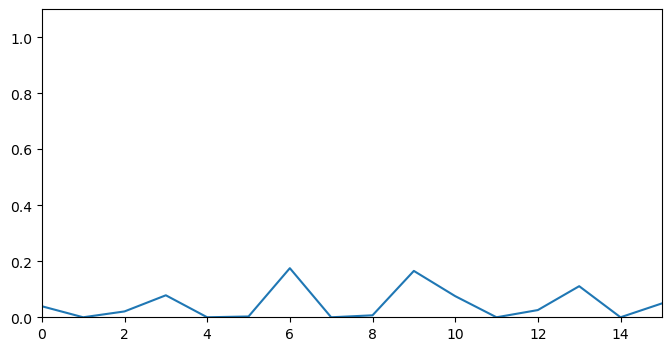

In [42]:
# Compute depth scores
depth_scores = get_depths(coherence_scores)

# Plot depth scores
plt.xlim(0, n-1)
plt.ylim(0, 1.1)
plt.plot(depth_scores)

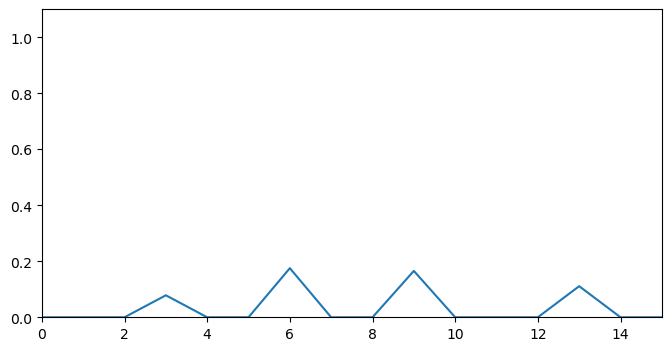

In [43]:
# Get local maxima
filtered_scores = get_local_maxima(depth_scores, order=1)

# Plot filtered scores
plt.xlim(0, n-1)
plt.ylim(0, 1.1)
plt.plot(filtered_scores)

In [44]:
# Automatic threshold computation
threshold = compute_threshold(filtered_scores)

In [52]:
# Select segments based on threshold
segment_ids = get_threshold_segments(filtered_scores, threshold)

print(threshold)

0.11278714255625741


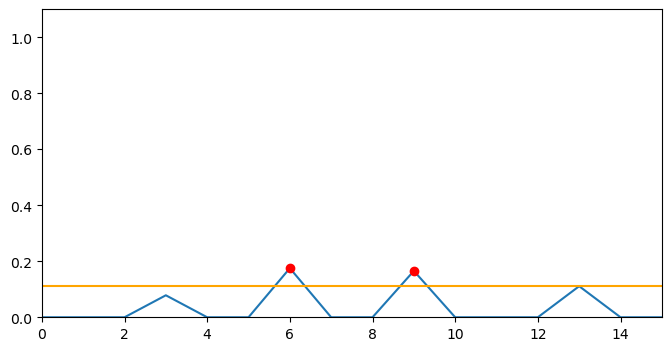

In [53]:
# Plot filtered scores
plt.xlim(0, n-1)
plt.ylim(0, 1.1)
plt.plot(filtered_scores)

# Plot threshold metadata
plt.plot(np.repeat(threshold, len(filtered_scores)), c='orange')
plt.plot(segment_ids, filtered_scores[segment_ids], 'o', c='red')

In [47]:
### Here

In [48]:
# Use computed ids to segment input document

segment_indices = segment_ids + WINDOW_SIZE

segment_indices = [0] + segment_indices.tolist() + [len(sents)]
slices = list(zip(segment_indices[:-1], segment_indices[1:]))

segmented = [sents[s[0]: s[1]] for s in slices]

In [49]:
# Print output

output = []
for elem in segmented:
    for i, s in enumerate(elem):
        output.append("- " + s.text)
    output.append("<SEGMENT>")
    
for elem in output:
    print(elem)

- Months before the Supreme Court overturned Roe v. Wade, the federal appeals court based in this Southern city cleared the way to ban most abortions in Texas.
- The same court appeared to jump the line to block the White House’s signature coronavirus vaccination mandate and split from other courts to back restrictions on social media companies and constrain President Biden’s immigration powers.
- The U.S. Court of Appeals for the 5th Circuit in New Orleans has long leaned conservative.
- But the arrival of a half-dozen judges picked by President Donald Trump — many of them young, ambitious and outspoken — has put the court at the forefront of resistance to the Biden administration’s assertions of legal authority and to the regulatory power of federal agencies.
- Their rulings have at times broken with precedent and exposed rifts among the judges, illustrating Trump’s lasting legacy on the powerful set of federal courts that operate one step below the Supreme Court.
- Even some veteran

In [50]:
# Save to file
with open('output/minilm_output.txt','w') as file:
    file.write('\n'.join(output))